# Building a Multi-Layer Perceptron

In [1]:
import numpy as np
import sklearn
import matplotlib
import pandas as pd
import sys
libraries = (('Matplotlib', matplotlib), ('Numpy', np), ('Pandas', pd))

print("Python Version:", sys.version, '\n')
for lib in libraries:
    print('{0} Version: {1}'.format(lib[0], lib[1].__version__))

Python Version: 3.6.2 |Anaconda custom (64-bit)| (default, Sep 21 2017, 18:29:43) 
[GCC 4.2.1 Compatible Clang 4.0.1 (tags/RELEASE_401/final)] 

Matplotlib Version: 2.0.2
Numpy Version: 1.12.1
Pandas Version: 0.20.3


In [2]:
import numpy as np

class Linear:
    
    def __init__(self, in_nodes, out_nodes):
        """
        Linear layers multiply inputs by weights, add a bias term
        and return that. We'll need to adjust the size of the weights
        to make sure it matches the output size.
        """
        self.params = {}
        self.gradient = {}
        self.set_starting_parameters(in_nodes, out_nodes)
        
    def set_starting_parameters(self, in_nodes, out_nodes):
        """
        Generate parameters from a random normal distribution
        centered on 0, with standard deviation of 1. There are
        other ways to generate weights, but this is empirically
        pretty effective. Note that our beta shape is (in, out)
        meaning the columns are what multiply each input vector
        when we do np.dot(X, beta).
        """
        self.params['beta'] = np.random.normal(0,1, size=(in_nodes, out_nodes))
        self.params['bias'] = np.random.normal(0,1, size=out_nodes)
        
    def forward_prop(self, inputs):
        """
        Do the matrix multiplication to the inputs by the weights
        to get the outputs.
        """
        weights = self.params['beta']
        bias = self.params['bias']
        self.inputs = inputs # need to save for use in our back prop!
        return np.dot(inputs, weights) + bias
    
    def backward_prop(self, gradient):
        """
        Determine the gradient with respect to each parameter,
        store that for later use updating parameters, then compute
        the gradient to send to the next layer back.
        """
        self.gradient['beta'] = np.dot(self.inputs.T,gradient)
        self.gradient['bias'] = np.sum(gradient, axis=0) # sum by column due to weight shape!
        return np.dot(gradient, self.params['beta'].T) # calculate the value of the gradient for the layer!

In [3]:
ln = Linear(3, 2)
data = np.random.uniform(0,1, size=(5,3))
ln.forward_prop(data)
# output shape should be rows of data, by 2 (output nodes requested!)

array([[-2.58824577, -3.36936111],
       [-3.41032002, -4.65041976],
       [-1.92096715, -2.19827796],
       [-1.7128935 , -2.85312238],
       [-2.8875099 , -3.35081895]])

In [4]:
class ActivationFunction:
    
    def __init__(self, function, function_derivative):
        """
        An activation function just manipuates an input by some
        given function and then passes it to the next layer. So
        given a function and its derivative (which we need for 
        backprop), we'll manipulate inputs.        
        
        Note that without knowing the activation functions this
        class is useless, so we need to use this as a parent class.
        """
        self.func = function
        self.func_prime = function_derivative
        # Need the below as place holders so we can iterate through 
        # all layers without breaking the code!
        self.params = {} 
        self.gradient = {}
        
    def forward_prop(self, inputs):
        """
        Take the inputs and apply the activation function to it
        """
        self.inputs = inputs # need to save for use in our back prop!
        return self.func(inputs)
    
    def backward_prop(self, gradient):
        """
        Return the gradient of the inputs and pass them backward.
        There are no weights to adjust on this, so we literally just
        return the gradient value.
        """
        primed_X = self.func_prime(self.inputs)
        return primed_X * gradient
    
class Tanh(ActivationFunction):
    
    def __init__(self):
        super().__init__(self._tanh, self._tanh_prime)
        
    def _tanh(self, X):
        """
        Using numpy's built in tanh function
        """
        return np.tanh(X)
    
    def _tanh_prime(self, X):
        """
        d(tanh)/dx = 1 - tanh(x)^2
        """
        func = np.tanh(X)
        return 1 - func**2
    
class Relu(ActivationFunction):
    
    def __init__(self):
        super().__init__(self._relu, self._relu_prime)
        
    def _relu(self, X):
        return X * (X > 0.)
    
    def _relu_prime(self, X):
        return 1. * (X > 0.)

In [5]:
t = Tanh()
t.forward_prop(data)

array([[ 0.50575765,  0.45454555,  0.60114599],
       [ 0.72427288,  0.24886318,  0.68997264],
       [ 0.09725102,  0.69221403,  0.75137374],
       [ 0.30032429,  0.04645858,  0.36274212],
       [ 0.61881447,  0.63761781,  0.49583935]])

In [6]:
np.tanh(data)

array([[ 0.50575765,  0.45454555,  0.60114599],
       [ 0.72427288,  0.24886318,  0.68997264],
       [ 0.09725102,  0.69221403,  0.75137374],
       [ 0.30032429,  0.04645858,  0.36274212],
       [ 0.61881447,  0.63761781,  0.49583935]])

In [7]:
r = Relu()
data = np.random.uniform(-1,1, size=(5,3))
print(data,"\n")
print(r.forward_prop(data))

[[-0.25428949  0.64465464 -0.48019155]
 [-0.86024017 -0.90718943  0.02887386]
 [-0.83040385 -0.3114109   0.26379757]
 [-0.94384869 -0.81747825 -0.30874283]
 [ 0.61090729 -0.01455527  0.08076331]] 

[[-0.          0.64465464 -0.        ]
 [-0.         -0.          0.02887386]
 [-0.         -0.          0.26379757]
 [-0.         -0.         -0.        ]
 [ 0.61090729 -0.          0.08076331]]


In [28]:
import numpy as np


class nn_regressor:
    
    def __init__(self, layer_sequence, epochs = 100, learning_rate = 0.001, random_state=None, 
                 batch_size=32, shuffle_data=True, verbose=False):
        """
        """
        self.layers = layer_sequence
        self.epochs = epochs
        self.learning_rate = learning_rate
        if random_state:
            np.random.seed(random_state)
        self.batch_size = batch_size
        self.shuffle_data = shuffle_data
        self.verbose = verbose
            
    def fit(self, X, y):
        """
        """
        X = self.convert_to_array(X)
        y = self.convert_to_array(y)
    
        for epoch in range(self.epochs):
            epoch_loss = 0.
            
            for x, target in self.get_data_batch(X,y):
                pred = self.forward_prop(x)
                pred_loss, gradient = self.loss(target, pred)
                #print("batch: ", pred_loss, " , ", gradient)
                epoch_loss += pred_loss
                gradient = self.backward_prop(gradient)
                
                for layer in self.layers:
                    self.update_weights(layer)
            if self.verbose:
                print("Epoch %i: %.3f"%(epoch, epoch_loss))
            
    def predict(self, X):
        """
        """
        X = self.convert_to_array(X)
        return self.forward_prop(X)
    
    def forward_prop(self, inputs):
        """
        Go layer by layer in the net, passing the input
        into the layer's forward prop method. The forward
        prop method will multiply the inputs or apply a function
        as defined in the layer. This eventually results in a
        prediction.
        """
        for layer in self.layers:
            inputs = layer.forward_prop(inputs)
        return inputs
    
    def backward_prop(self, gradient):
        """
        Go layer by layer in reverse, passing the gradient value backwards
        and using the layers specific backward prop behavior to calculate
        the gradient for each layer. Each layer can behave differently during
        back propogation, as specified by the layer.
        """
        for layer in self.layers[::-1]:
            gradient = layer.backward_prop(gradient)
        return gradient
    
    def update_weights(self, layer):
        """
        Use SGD to update the parameter by subtracting the gradient values
        scaled by the learning rate.
        """
        for name in layer.params.keys():
            layer.params[name] -= self.learning_rate*layer.gradient[name]
    
    def loss(self, true, pred):
        """
        Calculate the Sum of Squared Errors and the derivative of 
        SSE. Return both for use in the training.
        """
        loss = np.sum((pred-true)**2)
        grad = 2*(pred - true)
        return loss, grad
    
    def get_data_batch(self, X, y):
        batch_start = np.arange(0,len(X), self.batch_size)
        if self.shuffle_data:
            permute = np.random.permutation(np.arange(0,len(X)))
            X = X[permute]
            y = y[permute]
            
        for start in batch_start:
            X_batch = X[start:start+self.batch_size]
            y_batch = y[start:start+self.batch_size]
            yield X_batch, y_batch  
    
    def pandas_to_numpy(self, x):
        """
        Checks if the input is a Dataframe or series, converts to numpy matrix for
        calculation purposes.
        ---
        Input: X (array, dataframe, or series)
        Output: X (array)
        """
        if type(x) == type(pd.DataFrame()) or type(x) == type(pd.Series()):
            return x.as_matrix()
        if type(x) == type(np.array([1,2])):
            return x
        return np.array(x) 
    
    def handle_1d_data(self,x):
        """
        Converts 1 dimensional data into a series of rows with 1 columns
        instead of 1 row with many columns.
        """
        if x.ndim == 1:
            x = x.reshape(-1,1)
        return x
    
    def convert_to_array(self, x):
        """
        Takes in an input and converts it to a numpy array
        and then checks if it needs to be reshaped for us
        to use it properly
        """
        x = self.pandas_to_numpy(x)
        x = self.handle_1d_data(x)
        return x

    def score(self, X, y):
        """
        Uses the predict method to measure the (negative)
        mean squared error of the model.
        ---
        In: X (list or array), feature matrix; y (list or array) labels
        Out: negative mean squared error (float)
        """
        X = self.convert_to_array(X)
        y = self.convert_to_array(y)
        pred = self.predict(X)
        return -1.* np.mean((np.array(pred)-np.array(y))**2)

In [30]:
def gen_data(rows = 200, gen_coefs = [2,4], gen_inter = 0):
    X = np.random.rand(rows,len(gen_coefs))
    y = np.sum(np.tile(np.array(gen_coefs),(X.shape[0],1))*X,axis=1)
    y = y + np.random.normal(0,0.5, size=X.shape[0])
    y = y + gen_inter
    return X, y

actual_coefs = [5,3.5]
X, y = gen_data(gen_coefs=actual_coefs[1:], gen_inter=actual_coefs[0])

In [31]:
nn = nn_regressor([Linear(1, 1)], epochs=10, batch_size=2, verbose=True)
nn.fit(X,y)

Epoch 0: 909.279
Epoch 1: 65.189
Epoch 2: 57.522
Epoch 3: 53.144
Epoch 4: 50.196
Epoch 5: 48.083
Epoch 6: 47.387
Epoch 7: 46.494
Epoch 8: 46.114
Epoch 9: 46.325


In [32]:
preds = nn.predict(X)

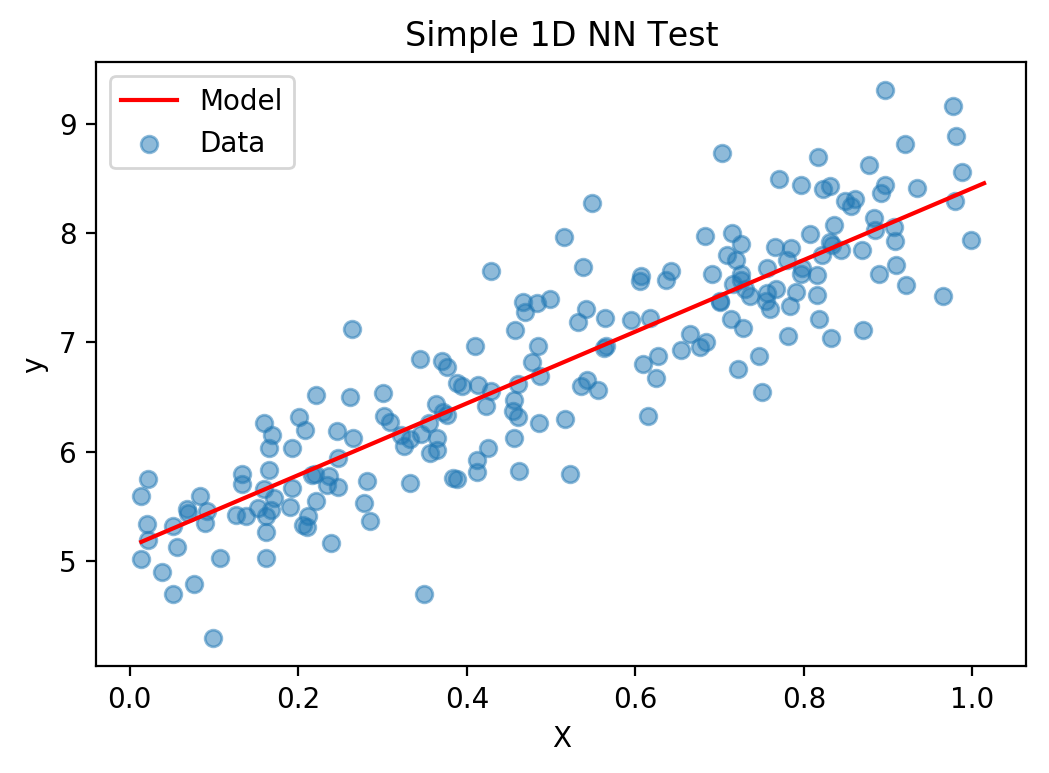

In [42]:
plt_x = np.arange(min(X),max(X)+0.1, .1)
plt_y = nn.predict(plt_x)
plt.figure(dpi=200)
plt.scatter(X,y, alpha=0.5, label="Data")
plt.plot(plt_x, plt_y, 'r-', label="Model")
plt.xlabel("X")
plt.ylabel("y")
plt.title("Simple 1D NN Test");
plt.legend(loc="upper left");

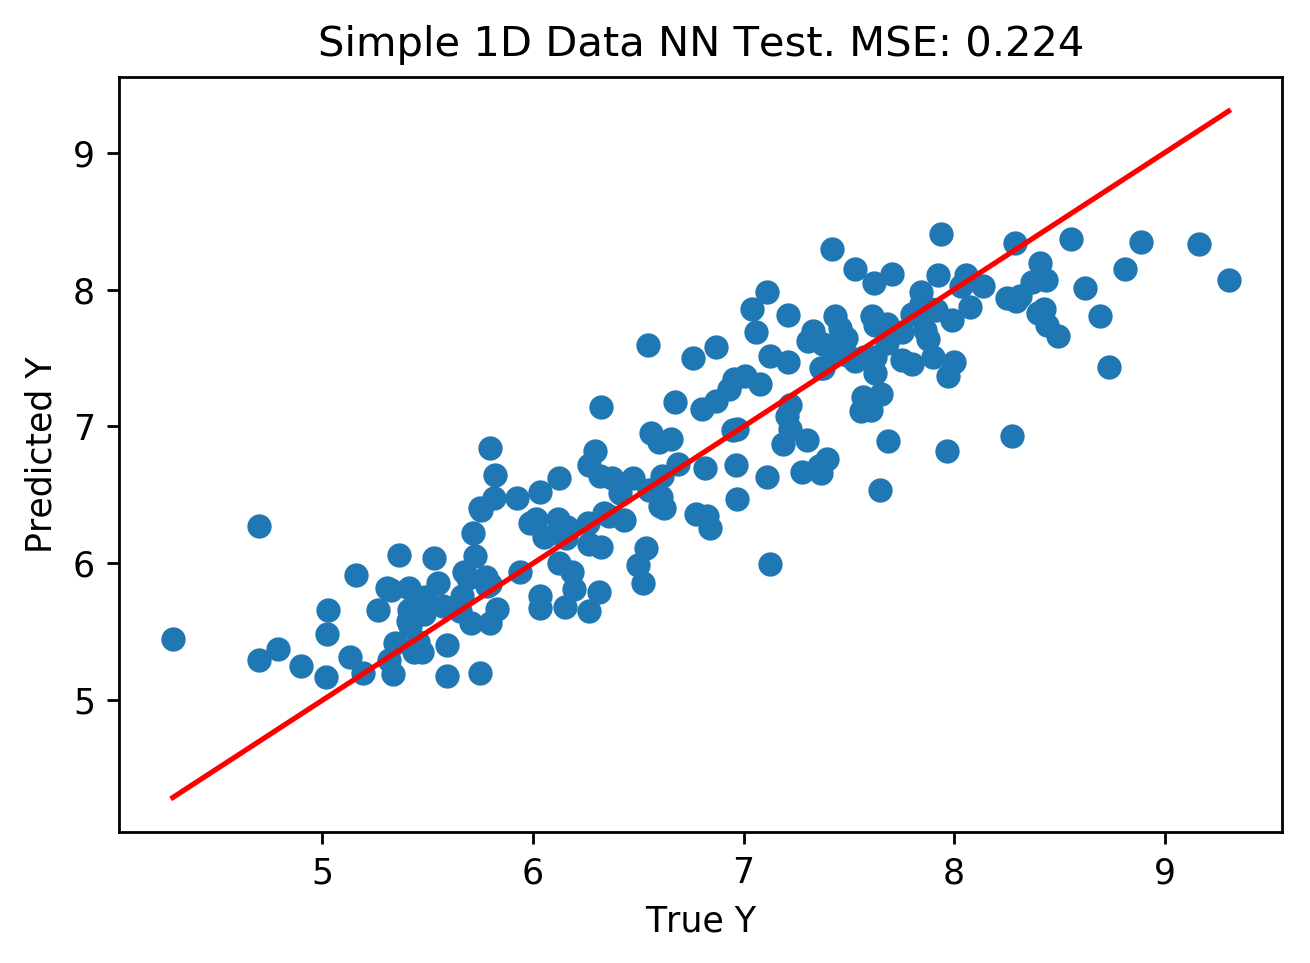

In [43]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(dpi=250)
plt.scatter(y, preds)
plt.plot([min(y),max(y)],[min(y),max(y)],'r-')
plt.xlabel("True Y")
plt.ylabel("Predicted Y")
plt.title("Simple 1D Data NN Test. MSE: %.3f"%(-nn.score(X,y)));

In [78]:
x = np.arange(0.0, 1, 0.01).reshape(-1, 1)
y = np.sin(2 * np.pi * x).ravel()
test_x = np.arange(0.0, 1, 0.01).reshape(-1, 1)
true_y = np.sin(2 * np.pi * test_x).ravel()

nn1 = nn_regressor([Linear(1,2), Tanh(), Linear(2,1)], batch_size=2, epochs=500)
nn2 = nn_regressor([Linear(1,10), Tanh(), Linear(10,1)], batch_size=2, epochs=500)
nn3 = nn_regressor([Linear(1,10), Relu(), Linear(10,1)], batch_size=2, epochs=500)
nn1.fit(x,y)
nn2.fit(x,y)
nn3.fit(x,y)

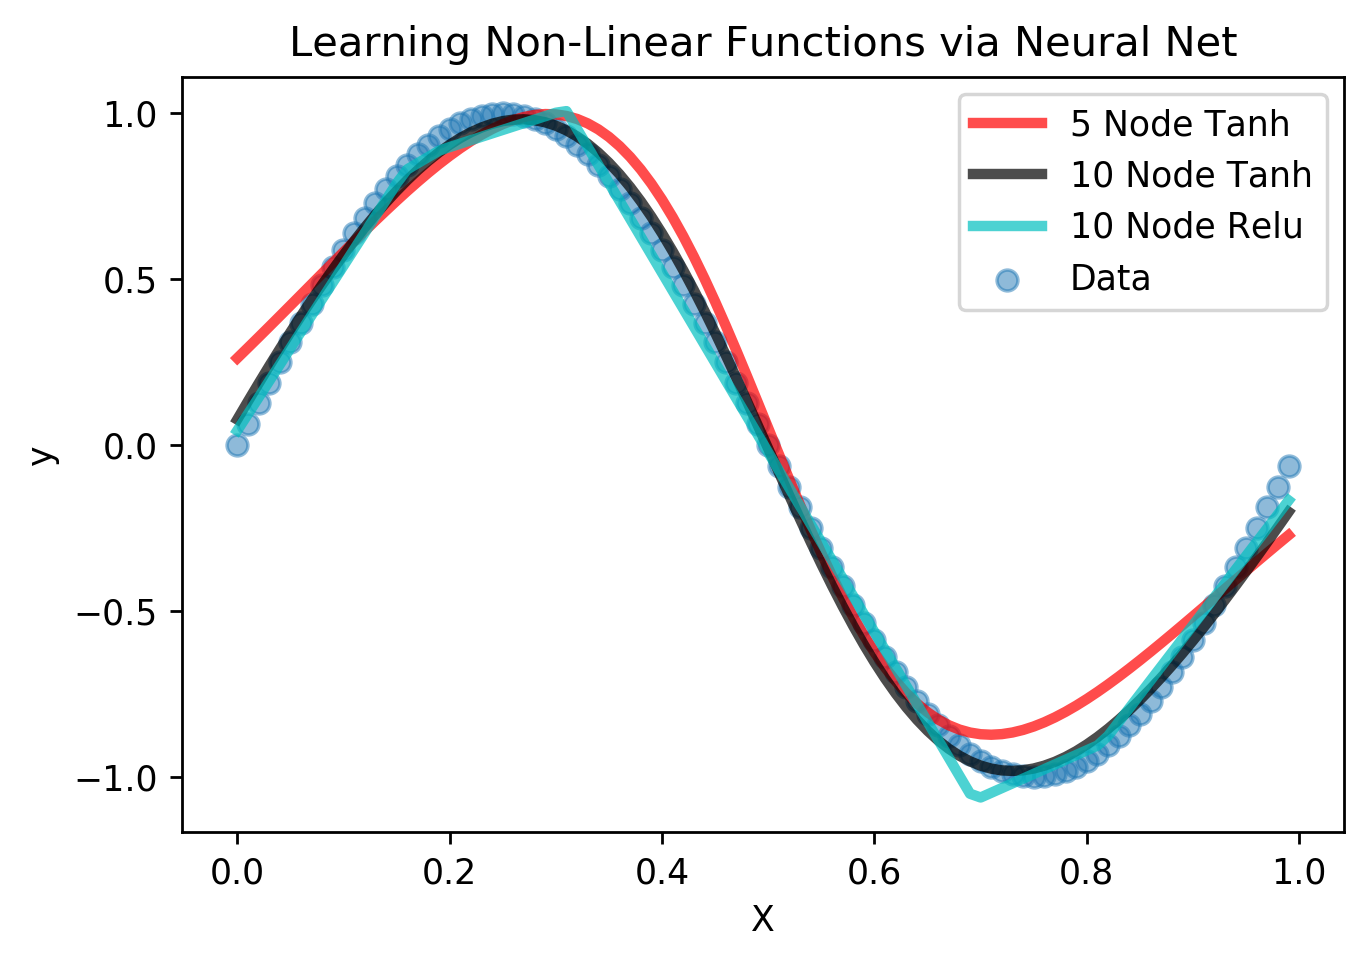

In [79]:
pred1 = nn1.predict(test_x)
pred2 = nn2.predict(test_x)
pred3 = nn3.predict(test_x)
plt.figure(dpi=250)
plt.scatter(x, y, alpha=0.5, label="Data")
plt.plot(test_x, pred1, c='r', lw=3, alpha=0.7, label="5 Node Tanh")
plt.plot(test_x, pred2, c='k', lw=3, alpha=0.7, label="10 Node Tanh");
plt.plot(test_x, pred3, c='c', lw=3, alpha=0.7, label="10 Node Relu");
plt.legend(loc="upper right");
plt.xlabel("X")
plt.ylabel("y")
plt.title("Learning Non-Linear Functions via Neural Net");

# Let's apply it to a toy dataset: Housing prices in Boston

In [168]:
from sklearn.datasets import load_boston

X = load_boston().data
y = load_boston().target

In [169]:
X.shape

(506, 13)

In [170]:
perm = np.random.permutation(len(X))
X = X[perm]
y = y[perm]

train_X = X[:400]
train_y = y[:400]
test_X = X[400:]
test_y = y[400:]

In [171]:
from sklearn.preprocessing import StandardScaler

ss = StandardScaler()
train_X = ss.fit_transform(train_X)
test_X = ss.transform(test_X)

In [172]:
nn = nn_regressor([Linear(13,50), Relu(), Linear(50,20), Relu(), Linear(20,1)], batch_size=20, 
                  learning_rate=1e-5, epochs=5000)
nn.fit(train_X,train_y)

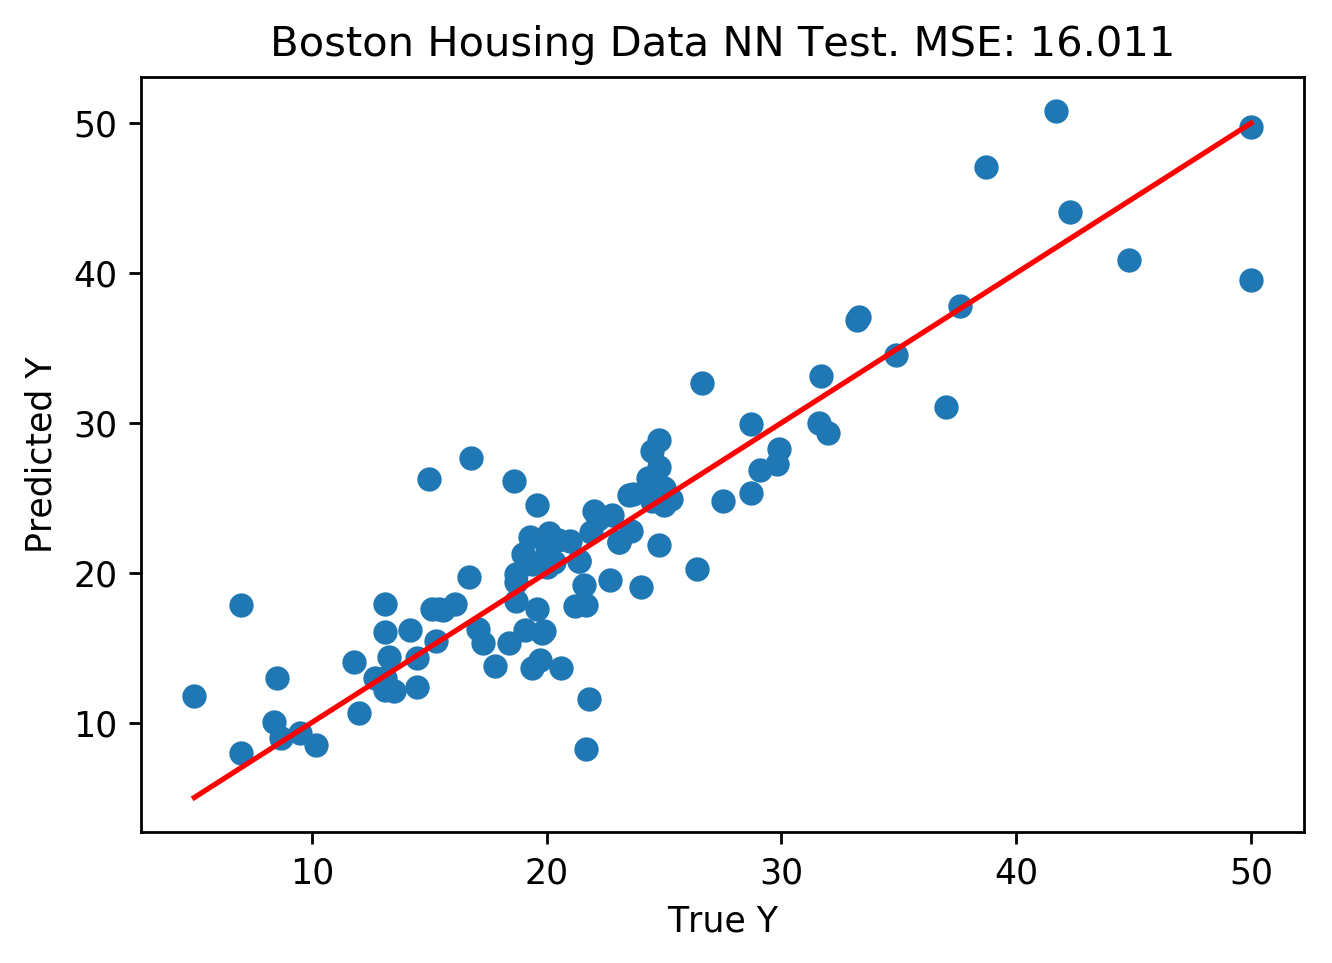

In [173]:
preds = nn.predict(test_X)

plt.figure(dpi=250)
plt.scatter(test_y, preds)
plt.plot([min(y),max(y)],[min(y),max(y)],'r-')
plt.xlabel("True Y")
plt.ylabel("Predicted Y")
plt.title("Boston Housing Data NN Test. MSE: %.3f"%(-nn.score(test_X,test_y)));

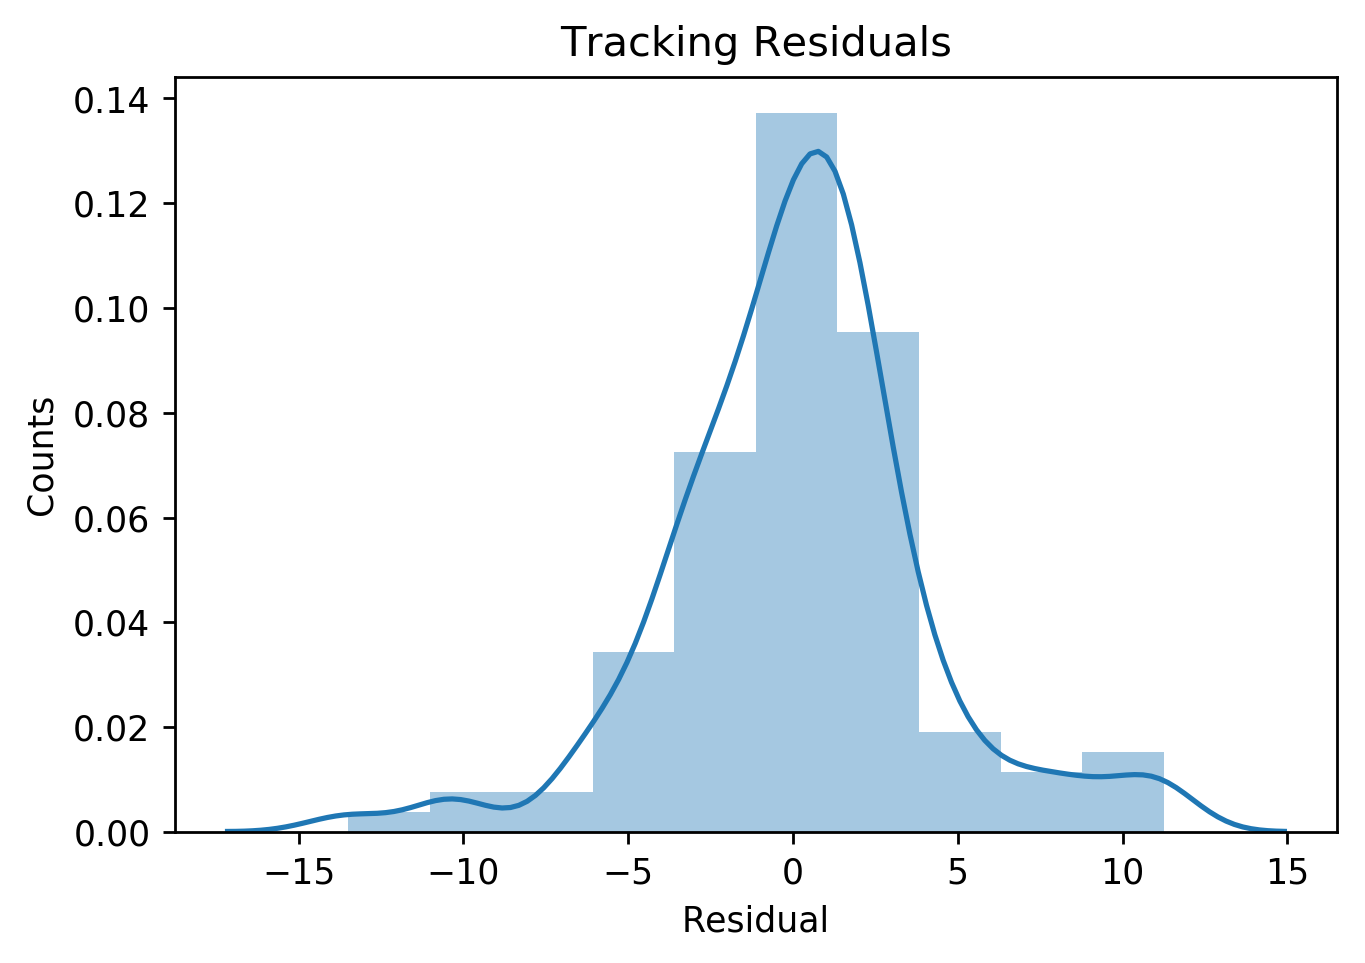

In [180]:
test_err = preds.ravel() - test_y.ravel()
import seaborn as sns

plt.figure(dpi=250)
sns.distplot(test_err, bins=10);
plt.xlabel("Residual")
plt.ylabel("Counts")
plt.title("Tracking Residuals");